In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
engine.execute("SELECT * FROM Measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
engine.execute("SELECT * FROM station").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [15]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [16]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date > '2016-08-22')\
    .order_by(Measurement.date).all()
prcp_df = pd.DataFrame(prcp_data)
prcp_df.set_index('date', inplace=True)
prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


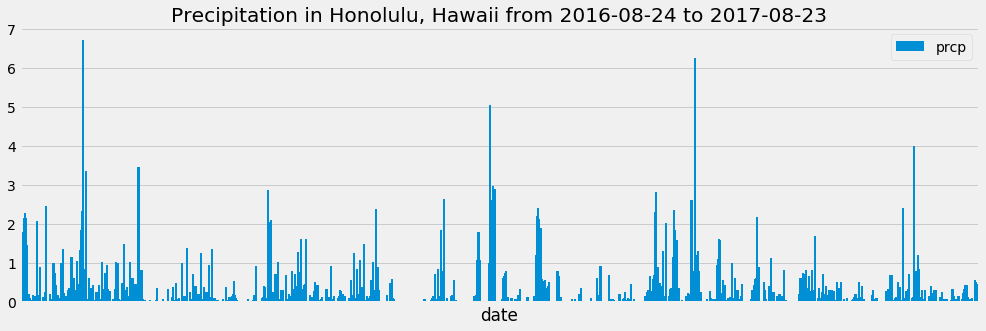

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.bar(figsize=(14,6), title="Precipitation in Honolulu, Hawaii from 2016-08-24 to 2017-08-23", grid=True, width=5)
plt.tight_layout()
plt.xticks([])
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Which station has the highest number of observations?
session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).first()

('USC00519281')

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281')\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).first()

(54.0, 85.0, 71.66378066378067)

In [24]:
# Query the last 12 months of temperature observation data for this station
tobs_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == 'USC00519281')\
    .filter(Measurement.date > '2016-08-22')\
    .order_by(Measurement.date).all()
tobs_df = pd.DataFrame(tobs_data)
tobs_df.set_index('date', inplace=True)
tobs_df.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


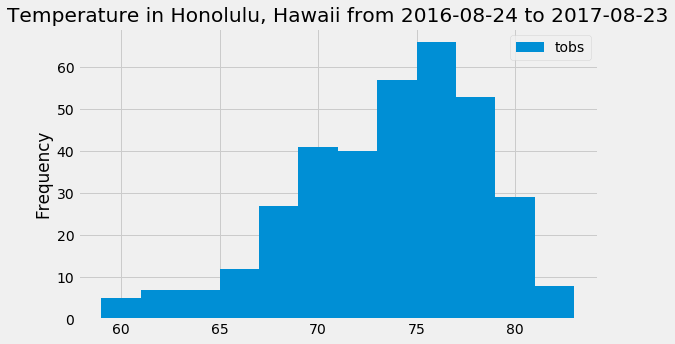

In [31]:
# Plot the results as a histogram
tobs_df.plot.hist(figsize=(9,5),title="Temperature in Honolulu, Hawaii from 2016-08-24 to 2017-08-23", grid=True, bins=12)
plt.tight_layout()
plt.show()